# Importing packages

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras.models import load_model

# Importing data and pre-processing

In [6]:
df=pd.read_csv(r"Asian_paints_15Y.csv",index_col="Date",parse_dates=True)
dfv=pd.read_csv(r"HINDUUNI_15Y.csv",index_col="Date",parse_dates=True)

In [7]:
#dropping rows with null values in the dataframe
df=df.dropna()
dfv=dfv.dropna()

In [8]:
#Reseting index column of the dataframe to Close
df1=df.reset_index()["Adj Close"]
dfv1=dfv.reset_index()["Adj Close"]

# Between period FY 2014-20 the indian markets experienced a boom, and the volatilty in the market also increased significantly
# Since the data before FY 2014 the had very low volatility, the amount of data available for training from the high volatility years was very limited, 
# which created a error in the validation set.
# To avoid this I have selected two large cap stocks whose performance were similar over the period under consideration.

In [9]:
# scaling the data in range (0,1)
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
df2=sc.fit_transform(np.array(df1).reshape(-1,1))
dfv2=sc.transform(np.array(dfv1).reshape(-1,1))

In [10]:
training_size=int(len(df))
training_data=df2[0:training_size,:]
test_size=(len(dfv))
test_data=dfv2[0:test_size,:]

In [11]:
# Convert an array of values into a dataset matrix
#creating the training data set
def create_dataset(dataset, timestep):
    dataX,dataY=[] , []
    for i in range (len(dataset)-timestep-1):
        a=dataset[i:(i+timestep),0]                         #Ex - storing the values from 1 to 50
        dataX.append(a)
        dataY.append(dataset[i+timestep, 0])     #Ex - The output will be 51st day closing price
    return  np.array(dataX), np.array(dataY)

In [12]:
# creating train data and test data
timestep=100
X_train, Y_train =create_dataset(training_data, timestep)
print("X_train will start from "+str(timestep)+" to "+str(len(training_data)-timestep) )
X_test, Y_test = create_dataset(test_data, timestep)

# the test set will be ==>  from (total - timestep-1) to (total-1)

X_train will start from 100 to 3778


In [13]:
# reshaping the in 3D
# for LSTM we have input shape as (n_x, m, T_x) -- 3D
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)   #Shape ==> ((training_size - timestep-1),timestep, 1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

# Model

In [ ]:
model =Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1],1)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam",metrics=[tf.keras.metrics.RootMeanSquaredError(
    name="root_mean_squared_error", dtype=None
)])

In [ ]:
model.summary()

#Summary shows the output shape of an LSTM

#input shape of LSSTM ==> (Batch_size, timesteps, input_dims)
#output shape of LSTM ==> (Batch_size, timesteps, number of units)      -- When return sequences is True
#output shape of LSTM ==> (Batch_size,  number of units)      -- When return sequences is False

# Training

In [ ]:
history=model.fit(X_train,Y_train,validation_data =(X_test, Y_test), epochs =50, 
                    batch_size=32,
                   verbose=1)

# Saving the trained model

In [ ]:
model.save("my_model.model",save_format="h5") 

# Importing saved model

In [14]:
model = load_model('my_model.h5')

# Validation

In [15]:
# Prediction
train_predict=model.predict(X_train)
test_predict= model.predict(X_test)

In [16]:
# Scale back the predictions to original values (Initally we had scaled down to range 0-1)
train_predict =sc.inverse_transform(train_predict)
test_predict =sc.inverse_transform(test_predict)

## Performance Metrics (RMSE)

In [17]:
import math 
from sklearn.metrics import mean_squared_error
Train_RMSE=math.sqrt(mean_squared_error(sc.inverse_transform(Y_train.reshape(-1,1)),train_predict))
Test_RMSE=math.sqrt(mean_squared_error(sc.inverse_transform(Y_test.reshape(-1,1)),test_predict))
Train_RMSE,Test_RMSE

## Validation plot

train end at  3877
test start at 3978
test end at 3877
Test length -101
The shape of X_test 3775


<Figure size 1152x432 with 0 Axes>

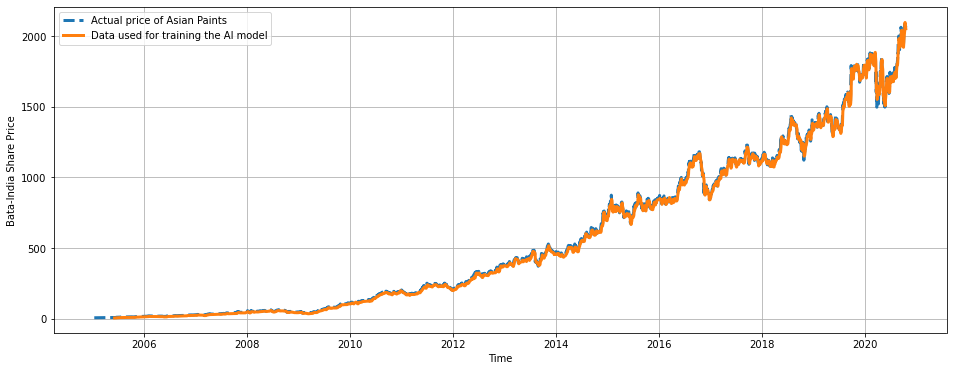

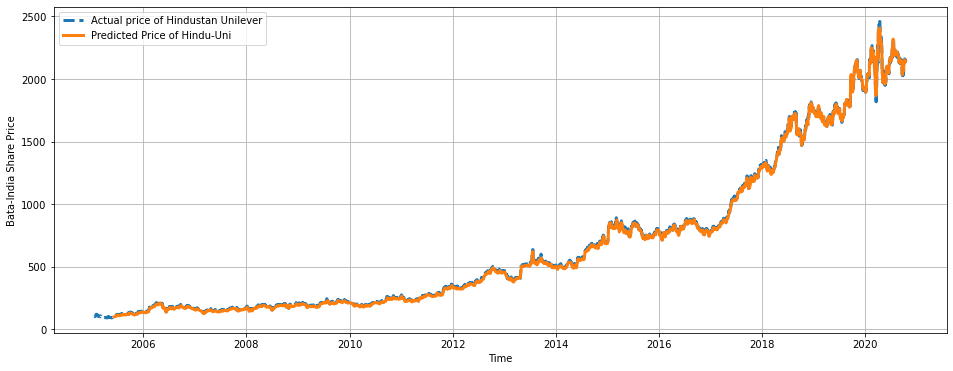

In [18]:
dates=np.array(df.index)
plt.figure(figsize=(16,6))
look_back=100
# Shift train predictions for plotting
trainplot=np.empty_like(df2)
trainplot[:, :] =np.nan
trainplot[look_back:len(train_predict)+look_back, :] = train_predict   
print("train end at ",len(train_predict)+look_back)

# Shift test predictions for plotting
testplot=np.empty_like(df2)
testplot[:, :] =np.nan

print("test start at",len(train_predict)+2*look_back+1)
print("test end at",len(df2)-1)
print("Test length",len(df2)-1-(len(train_predict)+2*look_back+1))
print("The shape of X_test",X_test.shape[0])

testplot[look_back:len(test_predict)+look_back, :] = test_predict     #For two share
#testplot[len(train_predict)+2*look_back+1:len(df2)-1, :] = test_predict        
#2*look_back covers the previous the previous 100 timesteps data included in training/testing the model
# For testing the data will come from (len(train_predict+look_back) : len(train_predict+2*look_back) ) 
#==> the first prediction will come at [len(train_predict)+2*look_back+1]

# Plotting baseline and predictions
plt.figure(figsize=(16,6))
plt.plot(dates,sc.inverse_transform(df2), linestyle='dashed',linewidth=3,label="Actual price of Asian Paints")
plt.plot(dates,trainplot,linewidth=3,label="Data used for training the AI model")
#plt.plot(dates,testplot,linewidth=3, label ="Predicted Price of BataIndia")
plt.xlabel('Time')
plt.ylabel('Bata-India Share Price')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(16,6))
plt.plot(dates[2:],sc.inverse_transform(dfv2), linestyle='dashed',linewidth=3,label="Actual price of Hindustan Unilever")
plt.plot(dates,testplot,linewidth=3, label ="Predicted Price of Hindu-Uni")
plt.xlabel('Time')
plt.ylabel('Bata-India Share Price')
plt.legend()
plt.grid()
plt.show()

# Prediciton

In [19]:
x_input=training_data[len(training_data)-100:].reshape(-1,1) #Taking previous day 100 data
temp_input=list(x_input)
x_input.shape

(100, 1)

In [20]:
from numpy import array
lst_output=[] #empty list
n_steps =100
i=0
while (i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])   #gets prev 100 day data from latest(updated) temp_input
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        x_input=tf.convert_to_tensor(x_input,dtype=tf.float32)
        
        yhat=model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        
        
print(lst_output)

[0.98303473]
101
1 day output [[0.9841088]]
2 day output [[0.9841702]]
3 day output [[0.9840176]]
4 day output [[0.98396873]]
5 day output [[0.98413897]]
6 day output [[0.98464084]]
7 day output [[0.9851701]]
8 day output [[0.9856397]]
9 day output [[0.9859215]]
10 day output [[0.9859667]]
11 day output [[0.9857507]]
12 day output [[0.98518646]]
13 day output [[0.9844769]]
14 day output [[0.9837326]]
15 day output [[0.9831588]]
16 day output [[0.9827759]]
17 day output [[0.98253906]]
18 day output [[0.98235357]]
19 day output [[0.9821154]]
20 day output [[0.9817618]]
21 day output [[0.981562]]
22 day output [[0.98141336]]
23 day output [[0.98136044]]
24 day output [[0.9814651]]
25 day output [[0.9817238]]
26 day output [[0.9820968]]
27 day output [[0.98246694]]
28 day output [[0.9827149]]
29 day output [[0.98274696]]
[[0.9830347299575806], [0.9841088056564331], [0.9841701984405518], [0.9840176105499268], [0.9839687347412109], [0.9841389656066895], [0.9846408367156982], [0.9851701259613

In [21]:
df3=df2.tolist()
df3.extend(lst_output) # adding the latest output to the existing data

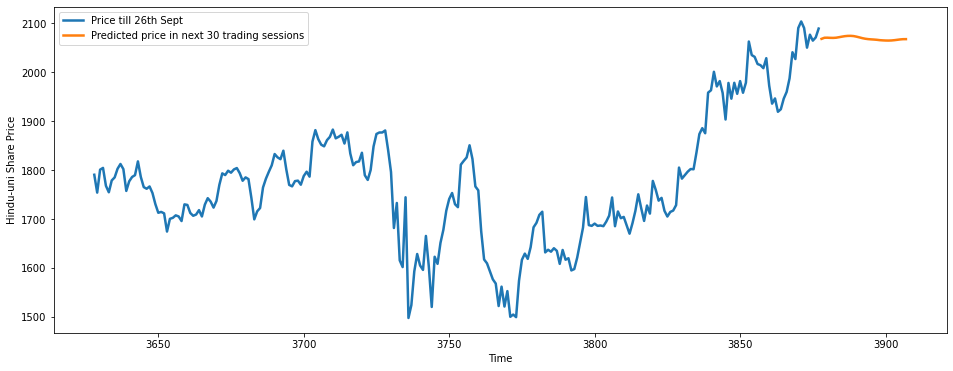

In [22]:
plt.figure(figsize=(16,6))

timeframe_prev =list(range(len(df2)-250, len(df2)))
plt.plot(timeframe_prev,sc.inverse_transform(df2[len(df2)-250:]), label="Price till 26th Sept",linewidth=2.5) 

timeframe =list(range(len(df2), len(df2)+30))
plt.plot(timeframe,sc.inverse_transform(lst_output), label="Predicted price in next 30 trading sessions",linewidth=2.5)

plt.xlabel('Time')
plt.ylabel('Hindu-uni Share Price')
plt.legend()
plt.show()

## Combined plot with previous data

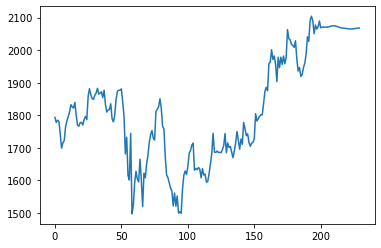

In [23]:
df3=df2.tolist()
df3.extend(lst_output)
plt.plot(sc.inverse_transform(df3[len(df2)-200:]))